<a href="https://colab.research.google.com/github/smartyro/FinalProject308/blob/main/Final_Project_CSC_369.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sophie Martyrossian - CSC 369 Final Project

## An analysis of Letterboxd Films for a specific genre, actor, and language.

### Data Used:
#### [Letterboxd](https://letterboxd.com/) is a social media platofrm based used by movie lovers. The app and website allows users to share, rate, bookmark, and keep track of movies, as well as connect with friends.
#### I found a [dataset](https://www.kaggle.com/datasets/whistlebug23/letterboxd-films) on Kaggle with 23,750 movies on this platform. Since this is a huge dataset, I wanted to find out which movies for a particular genre, actor, and language had the best reviews, as well as any possible correlations.

### Structure:
#### **LetterboxdAllFilms.csv**
#### - Film Link
#### - ID
#### - Film Base Link
#### - Film Ratings Link
#### - Film Title
#### - Film Year
#### - Runtime (Minutes)
#### - Director 1
#### - Director 2
#### - Cast (1-7)
#### - Role (1-7)
#### - Studio (1-3)
#### - Genre (1-5)
#### - Language (1-2)
#### - Country
#### - Ratings (0.5 to 5 stars)
#### - Average Rating (out of five)




In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=cbdd73ae8c3869e2f03d8bdcdab444d88e1659f222b05a1d8aa27185d6d41db0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:am

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, Window
from pyspark.sql import types as sparktypes
from pyspark.sql.functions import col, count, avg, format_number, round, desc

sc = SparkContext()
spark = SparkSession(sc)


# Questions

### With the release of Oppenheimer and Barbie last weekend, I wanted to compare ratings for films based on a variety of factors, such as language, genre, and actors.

## I chose the following questions:

#### 1. What are the top 20 highest rated films on Letterboxd?
#### 2. What are the top 20 directors on Letterboxd?
#### 3. Which actors star in the most movies with a rating of higher than 4 stars?
#### 4. What are the top 20 languages on Letterboxd, sorted by number of movies?
#### 5. What are the top 10 movies in the top 5 languages?
#### 6. What are the top 10 movies in Animation, Drama, Comedy, Thriller, and Adventure?
#### 7. Is there a relationship between genre and average ratings?
#### 8. What is the correlation coefficient between runtime and average ratings?
#### 9. What is the correlation coefficient between total reviews and average ratings?
#### 10. What is the correlation coefficient between release year and average ratings?


# Format of Data

Below is a DataFrame of the Letterboxd films file.

In [ ]:
df = spark.read.csv("LetterboxdAllFilms.csv", header=True, inferSchema=True)
df.show()

+--------------------+----+--------------------+--------------------+--------------------+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------------+--------------------+--------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------+---------+-------+-------+----------+----------+------------------+---------+--------+-------------+--------+-------------+----------+---------------+---------+--------------+---------+----------------+
|           Film.Link|  ID|      Film.Base.Link|   Film.Ratings.Link|          film.title|film.year|runtime|          director.1|          director.2|              cast.1|              role.1|              cast.2|             role.2|              cast.3|         role.3|           

# Question 1:
## What are the top 20 highest rated films on Letterboxd?
### Implementation:
#### - Filter out unnecessary columns
#### - Cast the review columns to integers
#### - Find the total reviews for each film, and calculate the averages
#### - Filter out films with higher than a review of 5.0, and null reviews, as well as those who have less reviews than average

In [ ]:
# Question 1:

from pyspark.sql.functions import col, count, avg, format_number, round, desc, expr, sum as sql_sum

film_info = ["`film.title`", "`film.year`", "`runtime`", "`director.1`", "`cast.1`", "`cast.2`", "`cast.3`", "`cast.4`",
                  "`cast.5`", "`cast.6`", "`cast.7`", "`genre.1`", "`genre.2`", "`genre.3`", "`genre.4`", "`genre.5`",
                  "`language.1`", "`language.2`", "`country`", "`AvgRating`"]

review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]

films = df.select(review_cols + film_info)

total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])
films = films.withColumn("TotalReviews", expr(total_reviews_expr))

avg_reviews = films.agg(avg("TotalReviews")).first()[0]

films = films.filter((col("AvgRating") <= 5) & (col("AvgRating").isNotNull()) & (col("TotalReviews") > avg_reviews))
films = films.withColumn("AvgRating", round(films["AvgRating"], 4))

films = films.select(film_info  + ["TotalReviews"])

films.orderBy(desc("TotalReviews"), desc("AvgRating") ).show()

+--------------------+---------+-------+-----------------+-------------------+--------------------+--------------------+----------------+------------------+--------------------+-------------------+---------------+---------------+---------------+---------------+-------+----------+----------+-----------+---------+------------+
|          film.title|film.year|runtime|       director.1|             cast.1|              cast.2|              cast.3|          cast.4|            cast.5|              cast.6|             cast.7|        genre.1|        genre.2|        genre.3|        genre.4|genre.5|language.1|language.2|    country|AvgRating|TotalReviews|
+--------------------+---------+-------+-----------------+-------------------+--------------------+--------------------+----------------+------------------+--------------------+-------------------+---------------+---------------+---------------+---------------+-------+----------+----------+-----------+---------+------------+
|            Parasi

# Question 2:
## What are the top 20 directors on Letterboxd?
### Implementation
#### - filter out unnecessary data
#### - filter out films with AvgRatings between 3.5 & 5, and those with a null AvgRating
#### - calculate TotalReviews per director
#### - filter the directors by those who have greater than average amounts of reviews (reduce outliers such as niche films)
#### - sort by number of reviews, number of films and average rating


In [ ]:
# Question 2:

from pyspark.sql.functions import col, when, count, lit, sum as sql_sum, expr

film_info = ["`director.1`", "`director.2`", "`country`", "`AvgRating`"]
review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]

director_films = df.select(film_info + review_cols)
director_films = director_films.filter((df.AvgRating <= 5) & (df.AvgRating.isNotNull() & (df.AvgRating >= 3.5) ))

total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])
director_films = director_films.withColumn("TotalReviews", expr(total_reviews_expr))

stack_expr = "stack(2, `director.1`, `director.2`) as director"
director_films = director_films.selectExpr("`director.1`", "`director.2`", "country", "AvgRating", "TotalReviews", stack_expr)

avg_reviews = director_films.agg(avg("TotalReviews")).first()[0]

directors = director_films.filter(col("director").isNotNull())\
                  .groupBy("director", "country")\
                  .agg(round(avg("AvgRating"), 4).alias("average_rating"),
                  sql_sum("TotalReviews").alias("total_reviews"),
                  count("*").alias("number_of_films"))

directors = directors.filter(col("total_reviews") > avg_reviews)

print("\nTop 20 Directors with Average Ratings of Greater Than 3.5 Stars: ")
directors.orderBy(col("total_reviews").desc(), col("number_of_films").desc(), col("average_rating").desc() ).show(n=20)




Top 20 Directors with Average Ratings of Greater Than 3.5 Stars: 
+-----------------+-----------+--------------+-------------+---------------+
|         director|    country|average_rating|total_reviews|number_of_films|
+-----------------+-----------+--------------+-------------+---------------+
|Quentin Tarantino|        USA|        3.9995|      3272114|              8|
| Steven Spielberg|        USA|        3.8929|      3147807|             15|
|Christopher Nolan|         UK|        4.1321|      3032607|              5|
|  Martin Scorsese|        USA|        3.9092|      2914832|             15|
|    David Fincher|        USA|        3.8986|      2659178|              7|
|    Anthony Russo|        USA|        3.8159|      2303434|              4|
|        Joe Russo|        USA|        3.8159|      2303434|              4|
|   Hayao Miyazaki|      Japan|        4.0984|      2186508|             11|
|      Pete Docter|        USA|        4.0209|      1935360|              4|
|     Edg

# Question 3:
## Which actors star in the most movies with a rating of higher than 3.5 stars?
### Implementation:
#### - Filter out the actors and the average ratings
#### - Remove all films with ratings lower than 3.5 stars, and sort from highest to lowest
#### - Count the amount of times an actor's name appears in the filtered data
#### - Create a new DataFrame with the top 20 actors whose names appear in the most top-rated films


In [ ]:
# Question 3:

from pyspark.sql.functions import col, when, count, lit

filtered_films = df.drop("Film.Link", "ID", "Film.Base.Link", "Film.Ratings.Link", "director.2", "role.1", "role.2", "role.3", "role.4", "role.5", "role.6", "role.7", "studio.1", "studio.2", "studio.3", "genre.4", "genre.5", "half.star",
             "one.star", "one.half.star", "two.star", "two.half.star", "three.star", "three.half.star", "four.star", "four.half.star", "five.star")
filtered_films = filtered_films.filter((filtered_films.AvgRating >= 3.5) & (filtered_films.AvgRating <= 5))

stack_expr = "stack(7, `cast.1`, `cast.2`, `cast.3`, `cast.4`, `cast.5`, `cast.6`, `cast.7`) as actor"
actors = filtered_films.selectExpr("*", stack_expr)

actors_high = actors.filter(col("actor").isNotNull())\
                  .groupBy("actor", "country")\
                  .agg(round(avg("AvgRating"), 4).alias("average_rating"), count("*").alias("count"))\
                  .orderBy(col("count").desc())

print("\nTop 20 Actors with the Most Movies with Average Ratings of Greater Than 3.5 Stars: ")
actors_high.show(n=20)



Top 20 Actors with the Most Movies with Average Ratings of Greater Than 3.5 Stars: 
+-----------------+-------+--------------+-----+
|            actor|country|average_rating|count|
+-----------------+-------+--------------+-----+
|    James Stewart|    USA|        3.8737|   23|
|  Koichi Yamadera|  Japan|        3.7613|   22|
|   Toshirō Mifune|  Japan|        3.9786|   21|
|   Robert De Niro|    USA|         3.873|   21|
|  Tatsuya Nakadai|  Japan|        4.0876|   20|
|  Humphrey Bogart|    USA|        3.8038|   19|
|        Tom Hanks|    USA|         3.835|   17|
|        Şener Şen| Turkey|        3.7384|   17|
|      Henry Fonda|    USA|        3.7672|   17|
|Samuel L. Jackson|    USA|        3.7459|   16|
| Gérard Depardieu| France|        3.6636|   16|
|    Joan Crawford|    USA|        3.7259|   16|
|       Chishū Ryū|  Japan|        4.0519|   16|
|   Dustin Hoffman|    USA|        3.7642|   16|
|    Michael Caine|     UK|        3.8169|   16|
|   Clint Eastwood|    USA|      

# Question 4:
## What are the top 20 languages on Letterboxd, sorted by number of movies?
### Implementation:
#### - select only the primary language
#### - show the top 20 languages, and their total ratings

In [ ]:
# Question 3:

from pyspark.sql.functions import col, when, count, lit

stack_expr = "stack(1, `language.1`) as language"
languages = df.selectExpr("*", stack_expr)

lang_high = languages.filter(col("language").isNotNull())\
                  .groupBy("language")\
                  .agg(count("*").alias("count"))\
                  .orderBy(col("count").desc())

print("\nTop 20 Languages on Letterboxd: ")
lang_high.show(n=20)



Top 20 Languages on Letterboxd: 
+---------------+-----+
|       language|count|
+---------------+-----+
|        English|15187|
|         French| 1291|
|       Japanese| 1117|
|        Italian|  643|
|        Spanish|  630|
|         German|  490|
|          Hindi|  444|
|         Korean|  360|
|     Portuguese|  344|
|        Turkish|  243|
|        Chinese|  237|
|      Cantonese|  219|
|        Russian|  167|
|        Swedish|  150|
|         Danish|  104|
|          Tamil|   94|
|Persian (Farsi)|   85|
|         Arabic|   71|
|          Dutch|   67|
|      Malayalam|   67|
+---------------+-----+
only showing top 20 rows



# Question 5:
## What are the top 10 movies in English, French, Japanese, Italian, and Spanish?
### Implementation:
#### - select films, runtime, year, director, languages, country, and average rating
#### - select films with each specific language
#### - sort from high to low ratings, and choose top 10

In [ ]:
# Question 4:

from pyspark.sql.functions import col, when, count, lit, desc


film_info = ["`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "`language.1`", "`language.2`"]
review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]
total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])

top_films = df.select(review_cols + film_info)

top_films = top_films.withColumn("TotalReviews", expr(total_reviews_expr))
top_films = top_films.drop("Film.Link", "ID", "Film.Base.Link", "Film.Ratings.Link", "director.2", "role.1", "role.2", "role.3", "role.4", "role.5", "role.6", "role.7", "studio.1", "studio.2", "studio.3", "genre.4", "genre.5")
avg_reviews = top_films.agg(avg("TotalReviews")).first()[0]

filtered_films = top_films.filter((top_films.AvgRating <= 5) & (top_films.TotalReviews > avg_reviews))
filtered_films = filtered_films.withColumn("AvgRating", round(filtered_films["AvgRating"], 4))

filtered_films = filtered_films.orderBy(desc("TotalReviews"))

stack_expr = "stack(2, `language.1`, `language.2`) as language"
languages = filtered_films.selectExpr("*", stack_expr)

lang_high = languages.filter(col("language").isNotNull())\
                  .groupBy("language")\
                  .agg(count("*").alias("count"))\
                  .orderBy(col("count").desc())

english = filtered_films.filter((col("`language.1`") == "English"))
english = english.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("AvgRating"), desc("TotalReviews"))

french = filtered_films.filter((col("`language.1`") == "French"))
french = french.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("AvgRating"), desc("TotalReviews"))

japanese = filtered_films.filter((col("`language.1`") == "Japanese"))
japanese = japanese.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("AvgRating"), desc("TotalReviews"))

italian = filtered_films.filter((col("`language.1`") == "Italian"))
italian = italian.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("AvgRating"), desc("TotalReviews"))

spanish = filtered_films.filter((col("`language.1`") == "Spanish"))
spanish = spanish.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("AvgRating"), desc("TotalReviews"))


print("\nTop 10 English Films: ")
english.show(n=10)

print("\nTop 10 French Films: ")
french.show(n=10)

print("\nTop 10 Japanese Films: ")
japanese.show(n=10)

print("\nTop 10 Italian Films: ")
italian.show(n=10)

print("\nTop 10 Spanish Films: ")
spanish.show(n=10)




Top 10 English Films: 
+---------+--------------------+--------------------+-------+---------+------------+
|film.year|          director.1|          film.title|country|AvgRating|TotalReviews|
+---------+--------------------+--------------------+-------+---------+------------+
|     1972|Francis Ford Coppola|       The Godfather|    USA|   4.5409|      459531|
|     1974|Francis Ford Coppola|The Godfather: Pa...|    USA|   4.5296|      268947|
|     1957|        Sidney Lumet|        12 Angry Men|    USA|   4.5229|      234384|
|     1994|      Frank Darabont|The Shawshank Red...|    USA|    4.452|      465019|
|     2018|      Rodney Rothman|Spider-Man: Into ...|    USA|   4.4264|      729070|
|     2008|   Christopher Nolan|     The Dark Knight|     UK|   4.4238|      773885|
|     1990|     Martin Scorsese|          GoodFellas|    USA|   4.4225|      388828|
|     1993|    Steven Spielberg|    Schindler's List|    USA|   4.4182|      282358|
|     1980|      Irvin Kershner|The Empir

# Question 6:
## What are the top movies in Animation, Drama, Comedy, Thriller, and Adventure?
### Implementation:
#### - select films, runtime, year, director, genres, country, and average rating
#### - select films with each specific genre
#### - sort from high to low ratings, and choose top 10

In [ ]:
# Question 6:

from pyspark.sql.functions import col, when, count, lit, desc


film_info = ["`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "`genre.1`", "`genre.2`", "`genre.3`", "`genre.4`", "`genre.5`"]
review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]
total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])

top_films = df.select(review_cols + film_info)

top_films = top_films.withColumn("TotalReviews", expr(total_reviews_expr))
avg_reviews = top_films.agg(avg("TotalReviews")).first()[0]

filtered_films = top_films.filter((top_films.AvgRating <= 5) & (top_films.TotalReviews > avg_reviews))
filtered_films = filtered_films.withColumn("AvgRating", round(filtered_films["AvgRating"], 4))

filtered_films = filtered_films.orderBy(desc("TotalReviews"))

stack_expr = "stack(5, `genre.1`, `genre.2`, `genre.3`, `genre.4`, `genre.5`) as genre"
genres = filtered_films.selectExpr("*", stack_expr)

lang_high = genres.filter(col("genre").isNotNull())\
                  .groupBy("genre")\
                  .agg(count("*").alias("count"))\
                  .orderBy(col("count").desc())

animation = filtered_films.filter((col("`genre.1`") == "animation") | (col("`genre.2`") == "animation") | (col("`genre.3`") == "animation") | (col("`genre.4`") == "animation") | (col("`genre.5`") == "animation"))
animation = animation.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("TotalReviews"), desc("AvgRating"))

drama = filtered_films.filter((col("`genre.1`") == "drama") | (col("`genre.2`") == "drama") | (col("`genre.3`") == "drama") | (col("`genre.4`") == "drama") | (col("`genre.5`") == "drama"))
drama = drama.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("TotalReviews"), desc("AvgRating"))

comedy = filtered_films.filter((col("`genre.1`") == "comedy") | (col("`genre.2`") == "comedy") | (col("`genre.3`") == "comedy") | (col("`genre.4`") == "comedy") | (col("`genre.5`") == "comedy"))
comedy = comedy.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("TotalReviews"), desc("AvgRating"))

thriller = filtered_films.filter((col("`genre.1`") == "thriller") | (col("`genre.2`") == "thriller") | (col("`genre.3`") == "thriller") | (col("`genre.4`") == "thriller") | (col("`genre.5`") == "thriller"))
thriller = thriller.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("TotalReviews"), desc("AvgRating"))

adventure = filtered_films.filter((col("`genre.1`") == "adventure") | (col("`genre.2`") == "adventure") | (col("`genre.3`") == "adventure") | (col("`genre.4`") == "adventure") | (col("`genre.5`") == "adventure"))
adventure = adventure.select("`film.year`", "`director.1`", "`film.title`", "country", "AvgRating", "TotalReviews").orderBy(desc("TotalReviews"), desc("AvgRating"))


print("\nTop 10 Animated Films: ")
animation.show(n=10)

print("\nTop 10 Drama Films: ")
drama.show(n=10)

print("\nTop 10 Comedy Films: ")
comedy.show(n=10)

print("\nTop 10 Thriller Films: ")
thriller.show(n=10)

print("\nTop 10 Adventure Films: ")
adventure.show(n=10)



Top 10 Animated Films: 
+---------+--------------+--------------------+-------+---------+------------+
|film.year|    director.1|          film.title|country|AvgRating|TotalReviews|
+---------+--------------+--------------------+-------+---------+------------+
|     2018|Rodney Rothman|Spider-Man: Into ...|    USA|   4.4264|      729070|
|     2001|Hayao Miyazaki|       Spirited Away|  Japan|   4.4731|      561172|
|     2015|   Pete Docter|          Inside Out|    USA|   3.8937|      553171|
|     2017|   Lee Unkrich|                Coco| Mexico|   4.1844|      514852|
|     2009|   Pete Docter|                  Up|    USA|   4.0683|      494987|
|     2007|     Brad Bird|         Ratatouille|    USA|   4.1144|      490625|
|     2020|   Pete Docter|                Soul|    USA|   4.0634|      479848|
|     2008|Andrew Stanton|              WALL·E|    USA|   4.1304|      473496|
|     1995| John Lasseter|           Toy Story|    USA|     4.17|      462011|
|     2004|     Brad Bird| 

# Question 7:
## Is there a relationship between genres and average ratings?
### Implementation:
#### - select AvgRating and genres
#### - group by genres and calculate averages for each
#### - sort by highest to lowest rating for each genre


Average Ratings by Genre:
+---------------+------------------+
|          genre|AverageGenreRating|
+---------------+------------------+
|    documentary|            4.1534|
|            war|            3.6204|
|        history|            3.5698|
|          drama|            3.5559|
|        western|             3.551|
|          crime|            3.4294|
|          music|             3.392|
|      animation|            3.3562|
|        mystery|            3.3319|
|        romance|            3.3245|
|       thriller|            3.2284|
|         comedy|            3.1782|
|        fantasy|            3.1355|
|         family|            3.1156|
|science-fiction|            3.1143|
|         horror|            3.1085|
|      adventure|            3.0965|
|         action|            3.0846|
|       tv-movie|            2.9874|
+---------------+------------------+

Average Movie Rating on Letterboxd: 3.31


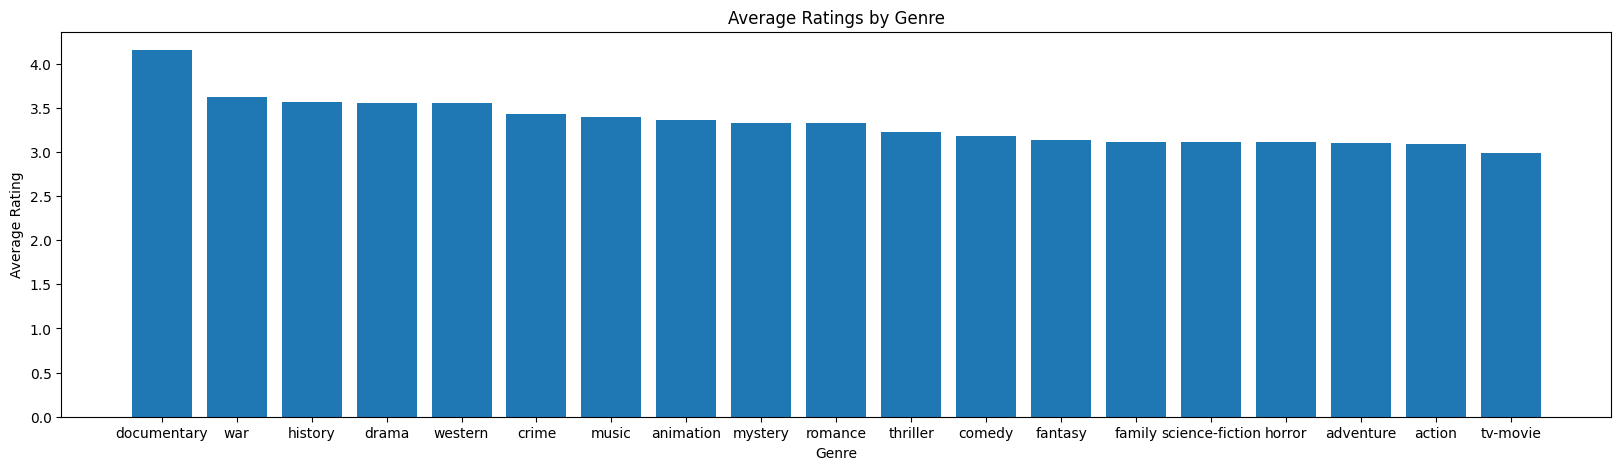

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, count, lit, desc, expr


film_info = ["AvgRating", "`genre.1`", "`genre.2`", "`genre.3`", "`genre.4`", "`genre.5`"]
review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]
total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])

top_films = df.select(review_cols + film_info)

filtered_films = filtered_films.withColumn("AvgRating", round(filtered_films["AvgRating"], 4))

all_avg = filtered_films.agg(avg("AvgRating")).first()[0]

stack_expr = "stack(5, `genre.1`, `genre.2`, `genre.3`, `genre.4`, `genre.5`) as genre"
genres = filtered_films.selectExpr("*", stack_expr).filter(col("genre").isNotNull())

genre_avgs = genres.groupBy("genre").agg(round(avg("AvgRating"), 4).alias("AverageGenreRating"))

print("\nAverage Ratings by Genre:")
genre_avgs.orderBy(desc("AverageGenreRating")).show()

print(f"Average Movie Rating on Letterboxd: {all_avg:.2f}")


pandas = genre_avgs.orderBy(desc("AverageGenreRating")).toPandas()

plt.figure(figsize=(20, 5))
plt.bar(pandas['genre'], pandas['AverageGenreRating'])

plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Genre')
plt.show()

# Question 8:
## What is the correlation coefficient between Runtime and Average Rating?
#### - select runtime and average rating
#### - find and print the correlation coefficient between them

In [ ]:
from pyspark.sql.functions import col, when, count, lit, desc, expr, corr

film_info = ["`runtime`", "AvgRating"]

film_runtimes = df.select(film_info)

correlation = film_runtimes.corr("`runtime`", "AvgRating")
print(f"\nCorrelation coefficient between Runtime and Average Rating: {correlation}")



Correlation coefficient between Runtime and Average Rating: 0.013110534660318812


# Question 9:
## What is the correlation coefficient between Total Reviews and Average Rating?
#### - select review columns and average rating
#### - find and print the correlation coefficient between them

In [ ]:
from pyspark.sql.functions import col, when, count, lit, desc, expr, corr

film_info = ["AvgRating"]
review_cols = ["`half.star`", "`one.star`", "`one.half.star`", "`two.star`", "`two.half.star`", "`three.star`", "`three.half.star`", "`four.star`","`four.half.star`", "`five.star`"]
total_reviews_expr = " + ".join([f"CAST({col} AS INT)" for col in review_cols])

film_reviews = df.select(review_cols + film_info)

top_films = top_films.withColumn("TotalReviews", expr(total_reviews_expr))
avg_reviews = top_films.agg(avg("TotalReviews")).first()[0]

filtered_films = top_films.filter((top_films.AvgRating <= 5) & (top_films.TotalReviews > avg_reviews))
filtered_films = filtered_films.withColumn("AvgRating", round(filtered_films["AvgRating"], 4))

filtered_films = filtered_films.orderBy(desc("TotalReviews"))

correlation = top_films.corr("TotalReviews", "AvgRating")
print(f"\nCorrelation between Total Reviews and Average Rating: {correlation}")



Correlation between Total Reviews and Average Rating: -0.0019646949149140663


# Question 10:
## What is the correlation coefficient between Release Year and Average Rating?
#### - select film.year and average rating
#### - find and print the correlation coefficient between them

In [ ]:
from pyspark.sql.functions import col, when, count, lit, desc, expr, corr

film_info = ["`film.year`", "AvgRating"]

film_years = df.select(film_info)

correlation = top_films.corr("`film.year`", "AvgRating")
print(f"\nCorrelation between Release Year and Average Rating: {correlation}")



Correlation between Release Year and Average Rating: 0.0023812258925935996


# Results:
## Question 1:
#### By looking at this data, it is clear that Parasite, the Korean drama film released in 2019 clearly outperforms all other films who have greater than average amounts of reviews. This is also evident later, when analyzing the top films across genres.

## Question 2:
#### In this analysis, it was concluded that, when comparing directors (with more reviews than average), and their average ratings, directors in the US consistently out-performed those in other countries.

## Question 3:
#### This pattern remain consistent when analyzing actors with the most movies containing average ratings of 3.5 or higher, with some few exceptions.

## Question 4:
#### I did not know which languages would have the most films on this platform, so for Question 5, I needed to see which languages were most common. I only selected films with the primary language, since English appeared in many films as a secondary language. By looking at this data, it is clear that English films make up the vast majority of films on this platform, which is not surprising, since this platform is only avaliable in English.

## Question 5:
#### Using the above data of top primary languages, I sorted the films based on primary languages for the top 5 languages, which were English, French, Japanese, Italian, and Spanish.

## Question 6:
#### Once again, it is clear that Parasite out-performs many other films, across all genres. Additionally, Christopher Nolan, the director of Oppenheimer, as well as Greta Gerwig, director of Barbie, both have films in the top 10 for Drama, Comedy, and Adventure.

## Question 7:
#### Most of the genres had average ratings of around average, which was 3.31. This is to be expected, since there weren't many outliers. The highest rated genre was Documentary, and the lowest-rated genre was TV Movies.

## Questions 8-10:
#### Based on the data, all the correlation coefficients had values close to 0, meaning that there was little data proving a correlation between Total Reviews, Runtime, and Release year with the Average Ratings. Therefore, we cannot conclude that these factors have a correlation with the Average Rating that a film will receive on Letterboxd.


# Conclusion:
### In sum, Letterboxd has a huge variety of films, across all genres. The reviews are pretty consistent across many factors, such as genre, run time, year, and total reviews.

### Additionally, in light of the recent SAG and WGA protests, it would be interesting to see the median pay for the cast and crew for the films, and compare it to the budget for each.